In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset, concatenate_datasets
from huggingface_hub import login
from matplotlib import pyplot as plt
from collections import Counter
from peft import LoraConfig, get_peft_model, AutoPeftModelForCausalLM
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments
import torch
import re
from tqdm import tqdm
import gc
from sklearn.metrics import f1_score
from dataclasses import dataclass
import os

In [ ]:
!pip install datasets bitsandbytes peft trl
from trl import SFTTrainer, SFTConfig

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
login("hf_token")

In [ ]:
!nvidia-smi

Wed Jul  2 17:44:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             54W /  350W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Loading the datasets. For this work, we used the Bac subset and the Comps subset from RoMath

In [ ]:
ro_math_bac_set = load_dataset('cosmadrian/romath', 'bac')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

romath-bac-train.csv:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

romath-bac-test.csv:   0%|          | 0.00/459k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4300 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1477 [00:00<?, ? examples/s]

Defining some global variables:
- Mathematical common latex tokens that will help us later
- The prompts for the model corresponding to their subsets


In [ ]:
MATHEMATICAL_TOKENS = [
      "\\frac", "\\sqrt", "\\lim", "\\int", "\\sum", "\\prod",
      "\\sin", "\\cos", "\\tan", "\\log", "\\ln", "\\cdot",
      "\\rightarrow", "\\to", "\\leq", "\\geq", "\\neq",
      "\\in", "\\approx", "\\mathbf{R}", "\\mathbb{R}", "\\pi",
      "^", "_", "\\left", "\\right", "\\operatorname", "="
  ]

baccalaureate_prompt = "Ești un elev în clasa a 12-a care se pregătește pentru examenul de Bacalaureat la matematică. Analizează foarte bine întrebarea și răspunde la exercițiile următoare oferind doar răspunsul final, fără explicații suplimentare. Dacă este cazul, folosește notații matematice în LaTeX pentru a scrie corect rezultatul."

Doing some basic exploratory data analysis:
- Visualizing the problems domain distribution across each subset
- Visualizing the distribution of the common mathematical tokens across each subset


To do that, we combined the training and test splits to get a better understanding of the distributions

In [ ]:
ro_math_bac_set_combined = concatenate_datasets([ro_math_bac_set['train'], ro_math_bac_set['test']])

In [ ]:
class DatasetAnalyzer:
    MATHEMATICAL_PATTERN_LATEX = re.compile(r"(\\[a-zA-Z]+|[=_^])")
    DOMAIN_COLUMN_NAME = 'domain'
    PROBLEM_COLUMN_NAME = 'problem'

    def __init__(self, ro_math_bac_set):
        self.data_subsets = {
            'bac': ro_math_bac_set
        }
        self.math_latex_tokens = MATHEMATICAL_TOKENS

    def get_domain_distribution(self, subset: str):
        if subset not in self.data_subsets:
            raise ValueError("Invalid data subset")
        counts = Counter(self.data_subsets[subset][self.DOMAIN_COLUMN_NAME])
        return dict(counts)

    def get_mathematical_tokens_distribution(self, subset: str):
        if subset not in self.data_subsets:
            raise ValueError("Invalid data subset")
        problems = self.data_subsets[subset][self.PROBLEM_COLUMN_NAME]
        freq = {tok: 0 for tok in self.math_latex_tokens}
        for p in problems:
            for sym in self.MATHEMATICAL_PATTERN_LATEX.findall(p):
                if sym in freq:
                    freq[sym] += 1
        return freq

In [ ]:
class DatasetVisualizer(DatasetAnalyzer):
    def __init__(self, ro_math_bac_set):
        super().__init__(ro_math_bac_set)

    def visualize_domain_distributions(self):
        subsets = list(self.data_subsets.keys())
        n = len(subsets)
        fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
        if n == 1:
            axes = [axes]

        for ax, subset in zip(axes, subsets):
            dist = self.get_domain_distribution(subset)
            labels, values = zip(*dist.items())
            ax.bar(labels, values)
            ax.set_title(f"{subset.upper()} domain distribution")
            ax.set_xticklabels(labels, rotation=70)
            ax.set_ylabel("Count")

        fig.suptitle("Domain Distribution Across Subsets", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def visualize_token_distributions(self):
        subsets = list(self.data_subsets.keys())
        n = len(subsets)
        fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
        if n == 1:
            axes = [axes]

        for ax, subset in zip(axes, subsets):
            freq = self.get_mathematical_tokens_distribution(subset)
            labels, values = zip(*freq.items())
            ax.bar(labels, values)
            ax.set_title(f"{subset.upper()} mathematical tokens distribution")
            ax.set_xticklabels(labels, rotation=70)
            ax.set_ylabel("Count")

        fig.suptitle("Mathematical Tokens Distribution Across Subsets", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

/tmp/ipython-input-10-852117019.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=70)


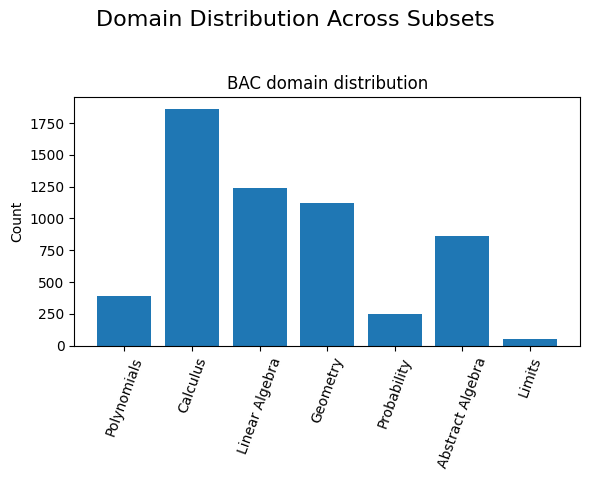

/tmp/ipython-input-10-852117019.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=70)


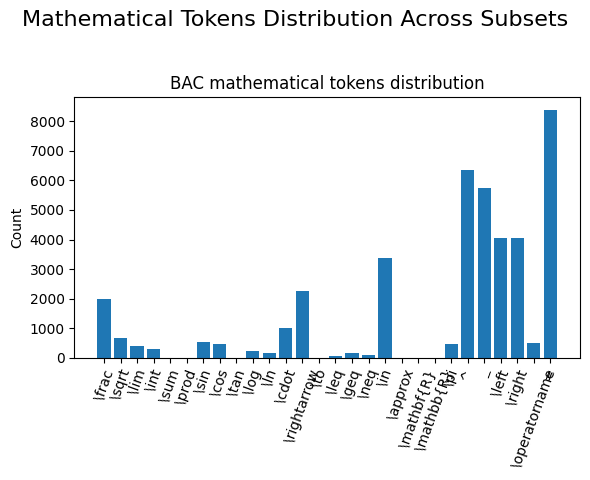

In [ ]:
dataset_visualizer = DatasetVisualizer(ro_math_bac_set_combined)
dataset_visualizer.visualize_domain_distributions()
dataset_visualizer.visualize_token_distributions()

Loading the model and the tokenizer.

For a better memory usage we quantized the model to 4bit.

We narrowed the LLM choice down to Ro-Llama and Ro-Mistral in the instruct format

In [ ]:
def load_model_and_tokenizer(model_name):
  bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16)

  model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  return model, tokenizer

model, tokenizer = load_model_and_tokenizer("OpenLLM-Ro/RoMistral-7b-Instruct")

config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

Now this is where the mathematical tokens come into play. Our idea is to add those mathematical tokens into the pre-trained tokenizer and then extend the model token embeddings

In [ ]:
tokens_to_add = [token for token in MATHEMATICAL_TOKENS if token not in tokenizer.get_vocab()]
tokenizer.add_tokens(tokens_to_add)
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(32793, 4096)

Formatting the dataset with the proper question-answering format. As an answer, we will stick to using the short answer to the problem, as reasoning for now is a little bit hard to do without any human supervision.

In [ ]:
def format_questions_answers(data_samples, llm_prompt):
  EOS_TOKEN = tokenizer.eos_token

  questions_column = data_samples['problem']
  answers_column = data_samples['solution']


  formatted_texts = []

  for question, answer in zip(questions_column, answers_column):
    full_formatted_answer = f'Răspunsul este {answer.strip()}'

    messages_ro_llm = [
      {"role": "system", "content": llm_prompt},
      {"role": "user", "content": question},
      {"role": "assistant", "content": full_formatted_answer + EOS_TOKEN}
    ]

    formatted_message = tokenizer.apply_chat_template(
        messages_ro_llm,
        tokenize = False,
        add_generation_prompt = False
    )

    formatted_texts.append(formatted_message)

  return {"text": formatted_texts}

In [ ]:
ro_math_bac_train = ro_math_bac_set['train']
ro_math_bac_eval = ro_math_bac_set['test']

ro_math_bac_train_updated = ro_math_bac_train.map(lambda x: format_questions_answers(x, baccalaureate_prompt), batched = True)
ro_math_bac_eval_updated = ro_math_bac_eval.map(lambda x: format_questions_answers(x, baccalaureate_prompt), batched = True)

Map:   0%|          | 0/4300 [00:00<?, ? examples/s]

Map:   0%|          | 0/1477 [00:00<?, ? examples/s]

In [ ]:
ro_math_bac_train_updated = ro_math_bac_train_updated.shuffle(seed = 42)

Using Low Rank Adaptation for fine tuning the models

For the changes, we applied the bias to lora_only allowing the biases to adapt during fine tuning
A dropout of 0.2 to introduce regularization and prevent overfitting

In [ ]:
peft_config = LoraConfig(
                          lora_alpha=16,
                          lora_dropout=0.2,
                          r=32,
                          bias="lora_only",
                          task_type="CAUSAL_LM",
                          target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ]
  )

In [ ]:
trainer = SFTTrainer(
    model = model,
    processing_class = tokenizer,
    train_dataset = ro_math_bac_train_updated,
    eval_dataset = ro_math_bac_eval_updated,
    peft_config = peft_config,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 600,
        max_seq_length = 1024,
        learning_rate = 2e-4,
        fp16 = True,
        bf16 = False,
        logging_steps = 100,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "output_math_qa_results",
    ),
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Adding EOS to train dataset:   0%|          | 0/4300 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/4300 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/4300 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/1477 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/1477 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1477 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Step,Training Loss
100,0.843400
200,0.637800
300,0.618200
400,0.577900
500,0.555800
600,0.548000


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=600, training_loss=0.6301798057556153, metrics={'train_runtime': 1063.718, 'train_samples_per_second': 2.256, 'train_steps_per_second': 0.564, 'total_flos': 2.547436162277376e+16, 'train_loss': 0.6301798057556153})

In [ ]:
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
cleanup()

In [ ]:
def compute_llm_eval_answers(eval_set, chat_instruction, model_ftuned, tokenizer_ftuned):
    llm_clean_answers = []

    for _, problem_instruction in enumerate(tqdm(eval_set)):
        chat = [
            {"role": "system", "content": chat_instruction},
            {"role": "user", "content": problem_instruction}
        ]


        prompt = tokenizer_ftuned.apply_chat_template(chat, tokenize = False)
        inputs = tokenizer_ftuned.encode(prompt, add_special_tokens=False, return_tensors="pt").to(model_ftuned.device)
        outputs = model_ftuned.generate(input_ids = inputs, max_new_tokens = 64)

        out = tokenizer_ftuned.decode(outputs[0])
        clean_answer = out.split('[/INST]')[1]
        clean_answer = clean_answer.replace('</s>', '').strip()

        llm_clean_answers.append(clean_answer)

    return llm_clean_answers

llm_clean = compute_llm_eval_answers(ro_math_bac_eval_updated['problem'], baccalaureate_prompt, model, tokenizer)

  0%|          | 0/1477 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
  0%|          | 1/1477 [00:08<3:33:08,  8.66s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
  0%|          | 2/1477 [00:09<1:46:50,  4.35s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `at

In [ ]:
pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
from bert_score import score

ground_truth_cleaned = []
for ans in ro_math_bac_eval_updated['problem']:
    parts = ans.split('[/INST]')
    if len(parts) > 1:
        cleaned_ans = parts[1].replace('</s>', '').strip()
    else:
        cleaned_ans = ans.replace('</s>', '').strip()

    ground_truth_cleaned.append(cleaned_ans)

min_len_bert = min(len(llm_clean), len(ground_truth_cleaned))
P, R, F1 = score(llm_clean[:min_len_bert], ground_truth_cleaned[:min_len_bert], lang="en", verbose=True)

print(f"Mean BERTScore F1: {F1.mean().item():.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/41 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/24 [00:00<?, ?it/s]

done in 10.96 seconds, 134.74 sentences/sec
Mean BERTScore F1: 0.8285


In [ ]:
import gradio as gr
import torch

# Function returns only the last Q&A
def compute_llm_eval_single(question, chat_instruction, model_ftuned, tokenizer_ftuned):
    chat = [
            {"role": "system", "content": chat_instruction},
            {"role": "user", "content": question}
        ]


    prompt = tokenizer_ftuned.apply_chat_template(chat, tokenize = False)
    inputs = tokenizer_ftuned.encode(prompt, add_special_tokens=False, return_tensors="pt").to(model_ftuned.device)
    outputs = model_ftuned.generate(input_ids = inputs, max_new_tokens = 64)

    out = tokenizer_ftuned.decode(outputs[0])
    clean_answer = out.split('[/INST]')[1]
    clean_answer = clean_answer.replace('</s>', '').strip()
    clean_answer="Q: "+question+"\nA: "+clean_answer
    return clean_answer

# Gradio wrapper
def gradio_interface(question):
    return compute_llm_eval_single(question, baccalaureate_prompt, model, tokenizer)

# Launch Gradio
gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(lines=4, label="Math Problem"),
    outputs=gr.Textbox(label="Model Answer"),
    title="Math Solver (LLM)",
    description="Enter a math problem and get a step-by-step answer with the final result.",
    allow_flagging="never"
).launch()

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8d5ef08e24ca25d397.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
